## Filtering for CRN with neural martingales

### Chemical Reaction Network setup

In [1]:
import pandas as pd
from CRN_Simulation_Inference.RB_method_for_model_identification.RBForModelIdentification import RBForModelIdentification
import numpy as np
import matplotlib.pyplot as plt  
from tqdm import tqdm
import torch
from ElenaDataManagement import count_samples_for_supersampling, get_X_Y_sampling_times, sample_trajectory_on_times, CRN_simulations_to_dataloaders, run_SSA_for_filtering

sigma = 0.1

species_names = ['G0', 'G1', 'mRNA']
stoichiometric_matrix = [[-1, 1, 0, 0],
                         [1, -1, 0, 0],
                         [0, 0, 1,-1]]
parameters_names = ['k1','k2', 'kp1']
reaction_names = ['G Act. 1', 'G Deg. 1', 'mRNA prod.', 'mRNA deg.']
propensities = [
    lambda k1, G0: k1*G0,
    lambda k2, G1: k2*G1,
    lambda kp1, G1: kp1*G1,
    lambda mRNA: mRNA
]

range_of_species = \
    pd.DataFrame([[0, 1], [0, 1], [0, 120]], index=species_names, columns=['min', 'max'])
range_of_parameters= \
    pd.DataFrame([[0, 1], [0, 1], [0, 150]],index=parameters_names,columns=['min', 'max'])
discretization_size_parameters = \
    pd.DataFrame([21, 21, 151], index=parameters_names) #index=parameters_names

# The observation related information
# h_function = [
#     lambda Protein: Protein
# ]
h_function = [
    lambda mRNA: mRNA # np.where(mRNA > 5, mRNA, 0)
]
observation_noise_intensity = [
    lambda : sigma
]
#observation_noise_intensity = {'sigma1': 0.1}


# sigma = 0.001

# species_names = ['mRNA']
# stoichiometric_matrix = [[1, -1]]
# parameters_names = ['k','g']
# reaction_names = ['mRNA prod.', 'mRNA deg.']
# propensities = [
#     lambda k: k,
#     lambda g, mRNA: g*mRNA,
# ]

# range_of_species = \
#     pd.DataFrame([[0, 120]], index=species_names, columns=['min', 'max'])
# range_of_parameters= \
#     pd.DataFrame([[0, 150], [0, 150]],index=parameters_names,columns=['min', 'max'])
# discretization_size_parameters = \
#     pd.DataFrame([100, 100], index=parameters_names) #index=parameters_names

# # The observation related information
# # h_function = [
# #     lambda Protein: Protein
# # ]
# h_function = [
#     lambda mRNA: mRNA # np.where(mRNA > 5, mRNA, 0)
# ]
# observation_noise_intensity = [
#     lambda : sigma
# ]
# #observation_noise_intensity = {'sigma1': 0.1}

maximum_size_of_each_follower_subsystem = 20000 #800 # 1000


MI = RBForModelIdentification(
    species_names=species_names,
    stoichiometric_matrix=stoichiometric_matrix,
    parameters_names=parameters_names,
    reaction_names=reaction_names,
    propensities=propensities,
    range_of_species=range_of_species,
    range_of_parameters=range_of_parameters,
    observation_noise_intensity=observation_noise_intensity,
    discretization_size_parameters=discretization_size_parameters,
    h_function=h_function,
    maximum_size_of_each_follower_subsystem=maximum_size_of_each_follower_subsystem)

print('leader species: ', MI.leader_species_time_course_data)
print('follower species: ', MI.get_follower_species_time_course_data())
print('follower parameters: ', MI.get_follower_parameters_time_course_data())

# import pandas as pd
# from CRN_Simulation_Inference.RB_method_for_model_identification.RBForModelIdentification import RBForModelIdentification
# import numpy as np
# import matplotlib.pyplot as plt  
# from tqdm import tqdm
# import torch
# from ElenaDataManagement import count_samples_for_supersampling, get_X_Y_sampling_times, sample_trajectory_on_times, CRN_simulations_to_dataloaders, run_SSA_for_filtering

# species_names = ['M', 'P']
# stoichiometric_matrix = [[1, 0, -1, 0],
#                          [0, 1, 0, -1]]
# parameters_names = ['b1','b2', 'd1', 'd2']
# reaction_names = ['Birth Mrna', 'Birthe Protein', 'Degrade Mrna', 'Degrade Protein']
# propensities = [
#     lambda b1: b1,
#     lambda b2, M: b2*M,
#     lambda d1, M: d1*M,
#     lambda d2, P: d2*P
# ]

# range_of_species = \
#     pd.DataFrame([[0, 100], [0, 100] ], index=species_names, columns=['min', 'max'])
# range_of_parameters= \
#     pd.DataFrame([[0, 10], [0, 10], [0, 10], [0, 10]],index=parameters_names,columns=['min', 'max'])
# discretization_size_parameters = \
#     pd.DataFrame([21, 21, 21, 21], index=parameters_names) #index=parameters_names

# # The observation related information
# # h_function = [
# #     lambda Protein: Protein
# # ]
# h_function = [
#     lambda P: P # np.where(mRNA > 5, mRNA, 0)
# ]
# observation_noise_intensity = [
#     lambda : 0.1
# ]
# #observation_noise_intensity = {'sigma1': 0.1}

# maximum_size_of_each_follower_subsystem = 20000 #800 # 1000


# MI = RBForModelIdentification(
#     species_names=species_names,
#     stoichiometric_matrix=stoichiometric_matrix,
#     parameters_names=parameters_names,
#     reaction_names=reaction_names,
#     propensities=propensities,
#     range_of_species=range_of_species,
#     range_of_parameters=range_of_parameters, 
#     observation_noise_intensity=observation_noise_intensity,
#     discretization_size_parameters=discretization_size_parameters,
#     h_function=h_function,
#     maximum_size_of_each_follower_subsystem=maximum_size_of_each_follower_subsystem)

# print('leader species: ', MI.leader_species_time_course_data)
# print('follower species: ', MI.get_follower_species_time_course_data())
# print('follower parameters: ', MI.get_follower_parameters_time_course_data())

leader species:  ['G1']
follower species:  ['G0', 'mRNA']
follower parameters:  ['kp1', 'k2', 'k1']


setup parameters and simulate a single trajectory (just for visualization)

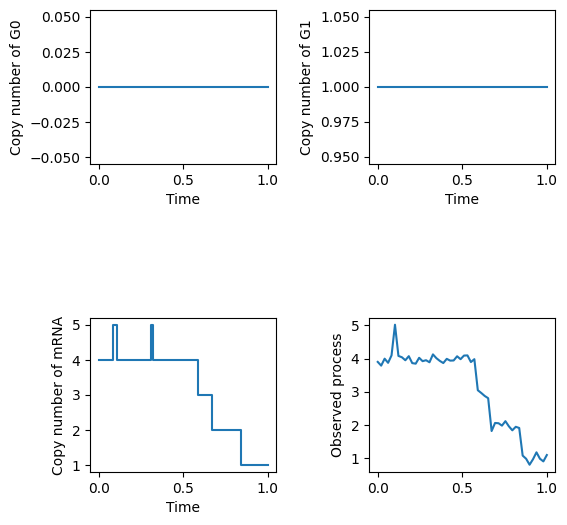

In [2]:
# Get a trajectory of the system
parameter_values_sets = []
# parameter_values_sets.append({'b1': 5, 'b2': 5, 'd1': 0.5, 'd2': 1}) # base parameters
parameter_values_sets.append({'k1': 1, 'k2': 1, 'kp1': 1})

# parameter_values_sets.append({'k': 1, 'g': 1})


parameter_set_index = 0
parameter_values = parameter_values_sets[parameter_set_index]
#initial_state = {'M': 0, 'P': 0}
initial_states = []
initial_states.append({'G0': 1, 'G1': 0, 'mRNA': 0})
initial_states.append({'G0': 0, 'G1': 1, 'mRNA': 0})
initial_states.append({'G0': 1, 'G1': 0, 'mRNA': 1})
initial_states.append({'G0': 0, 'G1': 1, 'mRNA': 1})
initial_states.append({'G0': 1, 'G1': 0, 'mRNA': 2})
initial_states.append({'G0': 0, 'G1': 1, 'mRNA': 2})
initial_states.append({'G0': 1, 'G1': 0, 'mRNA': 3})
initial_states.append({'G0': 0, 'G1': 1, 'mRNA': 3})
initial_states.append({'G0': 1, 'G1': 0, 'mRNA': 4})
initial_states.append({'G0': 0, 'G1': 1, 'mRNA': 4})
initial_states.append({'G0': 1, 'G1': 0, 'mRNA': 1})
initial_states.append({'G0': 0, 'G1': 1, 'mRNA': 1})
initial_states.append({'G0': 1, 'G1': 0, 'mRNA': 2})
initial_states.append({'G0': 0, 'G1': 1, 'mRNA': 2})
initial_states.append({'G0': 1, 'G1': 0, 'mRNA': 3})
initial_states.append({'G0': 0, 'G1': 1, 'mRNA': 3})

# for i in range(10):
#     initial_states.append({'mRNA': i})

tf = 1.0
import random
time_list, state_list, cPP = MI.SSA(initial_states[int(random.random()*len(initial_states))], parameter_values, 0, tf, compute_centered_poisson_process=True)
MI.plot_trajectories(time_list, state_list)

# Generate the observations

Observation_times_list = np.linspace(0, tf, 50)
Y_list = MI.generate_observations(state_list, time_list, parameter_values, Observation_times_list)

# plot the observations
plt.plot(Observation_times_list, Y_list)
plt.ylabel("Observed process")
plt.show()

visualize the centered Poisson Process

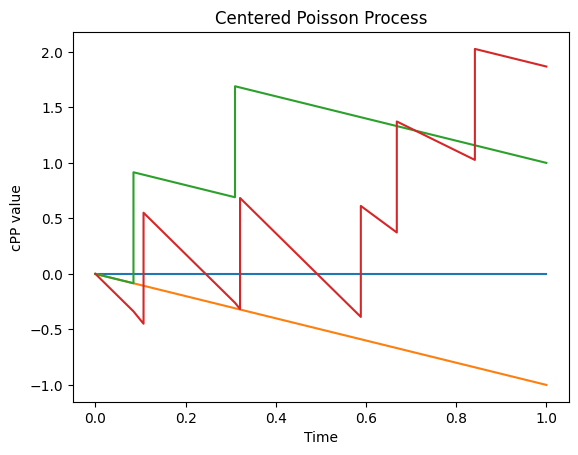

In [3]:
cPP.plot() 

### Debugging information

In [4]:
cPP.time_list

[0.0,
 np.float64(0.08432760253293015),
 np.float64(0.10664525595220771),
 np.float64(0.30949724416217395),
 np.float64(0.3206746279768608),
 np.float64(0.5885373202261603),
 np.float64(0.6683253984453261),
 np.float64(0.8414904182568629),
 np.float64(1.0)]

In [ ]:
cPP.current_a

[array([0., 1., 1., 4.]),
 array([0., 1., 1., 4.]),
 array([0., 1., 1., 5.]),
 array([0., 1., 1., 4.]),
 array([0., 1., 1., 5.]),
 array([0., 1., 1., 4.]),
 array([0., 1., 1., 3.]),
 array([0., 1., 1., 2.]),
 array([0., 1., 1., 1.])]

In [ ]:
cPP.centered_PP_mean

[array([0., 0., 0., 0.]),
 array([0.        , 0.0843276 , 0.0843276 , 0.33731041]),
 array([0.        , 0.10664526, 0.10664526, 0.44889868]),
 array([0.        , 0.30949724, 0.30949724, 1.26030663]),
 array([0.        , 0.32067463, 0.32067463, 1.31619355]),
 array([0.        , 0.58853732, 0.58853732, 2.38764432]),
 array([0.        , 0.6683254 , 0.6683254 , 2.62700855]),
 array([0.        , 0.84149042, 0.84149042, 2.97333859]),
 array([0.        , 1.        , 1.        , 3.13184817])]

In [ ]:
cPP.centered_PP

[array([0., 0., 0., 0.]),
 array([ 0.        , -0.0843276 ,  0.9156724 , -0.33731041]),
 array([ 0.        , -0.10664526,  0.89335474,  0.55110132]),
 array([ 0.        , -0.30949724,  1.69050276, -0.26030663]),
 array([ 0.        , -0.32067463,  1.67932537,  0.68380645]),
 array([ 0.        , -0.58853732,  1.41146268,  0.61235568]),
 array([ 0.        , -0.6683254 ,  1.3316746 ,  1.37299145]),
 array([ 0.        , -0.84149042,  1.15850958,  2.02666141]),
 array([ 0.        , -1.        ,  1.        ,  1.86815183])]

In [8]:
cPP.sample_at_times([9.99, 10., 10.01])

array([[  0.        ,  -9.99      ,  -7.99      ,  -7.12184817],
       [  0.        , -10.        ,  -8.        ,  -7.13184817],
       [  0.        , -10.01      ,  -8.01      ,  -7.14184817]])

In [ ]:
print(cPP.at(9.99))
print(cPP.at(10.01))

[ 0.         -9.99       -7.99       -7.12184817]
[  0.         -10.01        -8.01        -7.14184817]


In [ ]:
cPP.centered_PP_actual

[array([0., 0., 0., 0.]),
 array([0., 0., 1., 0.]),
 array([0., 0., 1., 1.]),
 array([0., 0., 2., 1.]),
 array([0., 0., 2., 2.]),
 array([0., 0., 2., 3.]),
 array([0., 0., 2., 4.]),
 array([0., 0., 2., 5.]),
 array([0., 0., 2., 5.])]

In [11]:
len(cPP.time_list)

9

In [ ]:
np.searchsorted(np.array(cPP.time_list), 0.01, side='right') - 1

np.int64(0)

In [ ]:
cPP.time_list

[0.0,
 np.float64(0.08432760253293015),
 np.float64(0.10664525595220771),
 np.float64(0.30949724416217395),
 np.float64(0.3206746279768608),
 np.float64(0.5885373202261603),
 np.float64(0.6683253984453261),
 np.float64(0.8414904182568629),
 np.float64(1.0)]

In [14]:
cPP.centered_PP

[array([0., 0., 0., 0.]),
 array([ 0.        , -0.0843276 ,  0.9156724 , -0.33731041]),
 array([ 0.        , -0.10664526,  0.89335474,  0.55110132]),
 array([ 0.        , -0.30949724,  1.69050276, -0.26030663]),
 array([ 0.        , -0.32067463,  1.67932537,  0.68380645]),
 array([ 0.        , -0.58853732,  1.41146268,  0.61235568]),
 array([ 0.        , -0.6683254 ,  1.3316746 ,  1.37299145]),
 array([ 0.        , -0.84149042,  1.15850958,  2.02666141]),
 array([ 0.        , -1.        ,  1.        ,  1.86815183])]

In [15]:
cPP.sample_at_times([9.99, 10.01])

array([[  0.        ,  -9.99      ,  -7.99      ,  -7.12184817],
       [  0.        , -10.01      ,  -8.01      ,  -7.14184817]])

In [16]:
cPP.at(9.99)

array([ 0.        , -9.99      , -7.99      , -7.12184817])

In [17]:
np.searchsorted(np.array(cPP.time_list), 9.99, side='right') - 1

np.int64(8)

### Dataloader structure

Let $\mathcal{T}$ be the set of measurement times, $\Tau$ the time discretization set, and $\mathcal{R}$ be the set of reactions. The dataloader should contain:

* $X(t) \forall t\in\Tau$ the full process 
* $Y(t) \forall t\in\mathcal{T}$ the observed process
* $\tilde{R}_k(t) \forall t\in\Tau, k\in \mathcal{R}$ the centered poisson process associated to the reaction $k$ 

this implies the following tensor dimensions (we condiser the batch size $B$) of the input tensors, respectively:

* $[B, |\Tau|, |X|]$
* $[B, |\mathcal{T}|, |y|]$
* $[B, |\Tau|, |r|]$


In [18]:
# # this can be done quickly by running 
# import math
# n_samples = 1000  # p in the paper
# batch_size = 100 #int(math.sqrt(n_samples))

# n_Y_measurements = 2 # n in the paper
# n_X_measurements_between_Y_measurements = 100 # m_bar-2 in the paper

# dataset = run_SSA_for_filtering(MI, initial_states, parameter_values, tf, n_Y_measurements, n_X_measurements_between_Y_measurements, n_samples=n_samples)
# train_dataset, val_dataset, Xtimes, Ytimes = CRN_simulations_to_dataloaders(dataset, batch_size, test_split=0.2)

# print("--- check batch sizes ---")
# print("training : ", [x.shape for x in next(iter(train_dataset))])
# print("validation : ", [x.shape for x in next(iter(val_dataset))])

In [19]:
# use SSA to compute the conditional expectations:

n_samples = 1000  # p in the paper
batch_size = 200 #int(math.sqrt(n_samples))

n_Y_measurements = 7 # n in the paper
n_X_measurements_between_Y_measurements = 30 # m_bar-2 in the paper

dataset = run_SSA_for_filtering(MI, initial_states, parameter_values, tf, n_Y_measurements, n_X_measurements_between_Y_measurements, n_samples=n_samples)
#train_dataset, val_dataset, Xtimes, Ytimes = CRN_simulations_to_dataloaders(dataset, batch_size, test_split=0.2)
train_dataset, val_dataset, Xtimes, Ytimes = CRN_simulations_to_dataloaders(dataset, batch_size, test_split=0.2)


100%|██████████| 1000/1000 [00:00<00:00, 1543.37it/s]


### Reimplementing DeepCME

In [20]:
# from OtherNetworks import MLP
# from DeepCME import DeepCME, TemporalFeatureExtractor


# r = 1                          # number of temporal features
# n = MI.get_number_of_species() # number of species

# g_functions = [
#     lambda x: x[:, 0],
#     lambda x: x[:, 1],
#     #lambda x: x[:, 0]**2,
#     #lambda x: x[:, 1]**2
# ]

# R = len(g_functions)
# K = MI.get_number_of_reactions()

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# temporal_feature_extractor = TemporalFeatureExtractor(r, tf, device=device)
# L = 2                          # number of layers
# backbone = MLP(2*r+n, L, R*K, L, activation=torch.nn.ReLU, postprocessing_layer=None).to(device)

# tau_list = torch.linspace(0, tf, n_X_measurements_between_Y_measurements+2)

# delta_threshold = torch.tensor([])

# deepCME = DeepCME(backbone, tau_list, g_functions, temporal_feature_extractor, R, K, device=device)


In [21]:
# def deepCME_training_loop(model, train_loader, optimizer, n_epochs, validation_loader=None, scheduler=None):
#     training_loss = []
#     validation_loss = []
#     for epoch in range(n_epochs):
#         for i, (X, Y, R) in enumerate(train_loader):
#             X = X.to(model.device)
#             Y = Y.to(model.device)
#             R = R.to(model.device)
#             optimizer.zero_grad()
#             loss = model.loss(X, R)
#             loss.backward()
#             optimizer.step()
#             if scheduler is not None:
#                 scheduler.step()
#             if epoch % 10 == 0:
#                 print(f'Training: Epoch {epoch}, batch {i}, Loss {loss.item()}')
#             training_loss.append((epoch*len(train_loader) + i, loss.item()))
#         if epoch % 10 == 0 and validation_loader is not None:
#             for i, (X, Y, R) in enumerate(validation_loader):
#                 with torch.no_grad():
#                     X = X.to(model.device)
#                     Y = Y.to(model.device)
#                     R = R.to(model.device)
#                     loss = model.loss(X, R)
#                     validation_loss.append((epoch*len(validation_loader) + i, loss.item()))
#                     if i % 10 == 0:
#                         print(f'Validation: Epoch {epoch}, batch {i}, Loss {loss.item()}')
#     return training_loss, validation_loss

# optimizer = torch.optim.Adam(deepCME.parameters(), lr=0.01)
# n_epochs = 1000
# training_loss, validation_loss = deepCME_training_loop(deepCME, train_dataset, optimizer, n_epochs, validation_loader=val_dataset)

In [22]:
# deepCME.Y

In [23]:
# raise Exception("Stop here")

### New implementation based on deepCME

In [24]:

from OtherNetworks import MLP, RNNEncoder
from DeepCME import FilteringDeepCME, TemporalFeatureExtractor
from copy import deepcopy

def deepcopy_flatten(x):
    other = deepcopy(x)
    if type(x) == RNNEncoder:
        other.RNN.flatten_parameters()
    return other


r = 1                          # number of temporal features
n = MI.get_number_of_species() # number of species
O = 1 # number of observed species

# BD 
# g_functions = [
#     lambda x: x[:, 0],
#     # lambda x: x[:, 1],
#     # lambda x: x[:, 2],
#     lambda x: x[:, 0]*0. + 1., # constant function
#     #lambda x: x[:, 0]**2,
#     #lambda x: x[:, 1]**2
# ]

g_functions = [
    lambda x: x[:, 0],
    lambda x: x[:, 1],
    lambda x: x[:, 2],
    lambda x: x[:, 0]*0. + 1.,
    lambda x: x[:, 0]**2,
    lambda x: x[:, 1]**2,
    lambda x: x[:, 2]**2
]

R = len(g_functions)
K = MI.get_number_of_reactions()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

temporal_feature_extractor = TemporalFeatureExtractor(r, tf, device=device)

x_hidden_size = 16
x_encoder = MLP(n, x_hidden_size, x_hidden_size, 2, activation=torch.nn.ReLU, postprocessing_layer=None).to(device)
y_hidden_size = 64
#postproc = MLP(y_hidden_size, y_hidden_size, y_hidden_size, 2, activation=torch.nn.ReLU, postprocessing_layer=None).to(device)
y_encoder = RNNEncoder(O, y_hidden_size, activation=None).to(device)

L = 3                          # number of layers
hidden_size = 32
backbone = MLP(2*r+x_hidden_size+y_hidden_size, hidden_size, R*K, L, activation=torch.nn.ReLU, postprocessing_layer=None).to(device)
#baseline_net = MLP(2*r+x_hidden_size+y_hidden_size, hidden_size, R, L, activation=torch.nn.ReLU, postprocessing_layer=torch.nn.Softplus()).to(device)
#baseline_net = MLP(x_hidden_size+y_hidden_size, hidden_size, R, L, activation=torch.nn.ReLU, postprocessing_layer=torch.nn.Softplus()).to(device) # without time
baseline_net = MLP(x_hidden_size+y_hidden_size, hidden_size, R, L, activation=torch.nn.ReLU, postprocessing_layer=None).to(device) # without time


tau_list = torch.linspace(0, tf, n_X_measurements_between_Y_measurements+2)

# n_Y_measurements = 2 # n in the paper
# n_X_measurements_between_Y_measurements = 100 # m_bar-2 in the paper

measurement_times = torch.linspace(0, tf, n_Y_measurements)
tau_times = torch.linspace(0, tf/(n_Y_measurements-1), n_X_measurements_between_Y_measurements+2)

# likelihoods and h functions
from ElenaLosses import likelihood_GaussianNoise_vmap_compatible

def h_fun(x):
    out = x[:, 2:3]
    #out = x
    return out

sigma_prior = sigma
likelihood = likelihood_GaussianNoise_vmap_compatible
likelihood_parameters = {'noise_covariance': (torch.eye(1)*sigma_prior).to(device)}
likelihood_parameters["noise_covariance_determinant"] = torch.det(likelihood_parameters["noise_covariance"])
likelihood_parameters["noise_covariance_inverse"] = torch.inverse(likelihood_parameters["noise_covariance"])


chain = []
for i in range(n_Y_measurements-2,-1,-1):
    print(i)
    if i == n_Y_measurements-2:
        chain.append(FilteringDeepCME(deepcopy_flatten(backbone), deepcopy_flatten(x_encoder), deepcopy_flatten(y_encoder), deepcopy_flatten(baseline_net), tau_times, measurement_times, g_functions, deepcopy_flatten(temporal_feature_extractor), R, K, O, position_in_the_chain=i, n_NN_in_chain=n_Y_measurements-1, device=device, h_transform=h_fun, likelihood=likelihood, likelihood_parameters=likelihood_parameters, next_in_chain=None))
    else:
        chain.append(FilteringDeepCME(deepcopy_flatten(backbone), deepcopy_flatten(x_encoder), deepcopy_flatten(y_encoder), deepcopy_flatten(baseline_net), tau_times, measurement_times, g_functions, deepcopy_flatten(temporal_feature_extractor), R, K, O, position_in_the_chain=i, n_NN_in_chain=n_Y_measurements-1, device=device, h_transform=h_fun, likelihood=likelihood, likelihood_parameters=likelihood_parameters, next_in_chain=chain[-1]))


5
4
3
2
1
0


In [26]:
def deepCME_training_loop(model, train_loader, optimizer, n_epochs, validation_loader=None, scheduler=None, sigma_decay_factor=0.5, sigma_decay_every=200, sigmamin=0.1, print_every=1):
    training_loss = []
    validation_loss = []
    best_model = model.state_dict()
    best = torch.tensor(float('inf'))
    for epoch in range(n_epochs):
        temp_loss = 0.
        for i, (X, Y, R) in enumerate(train_loader):
            X = X.to(model.device)
            Y = Y.to(model.device)
            R = R.to(model.device)
            def closure():
                optimizer.zero_grad()
                loss = model.loss(X, Y, R)
                training_loss.append((epoch*len(train_loader) + i, loss.item()))
                loss.backward()
                return loss
            optimizer.step(closure)
            temp_loss += training_loss[-1][1]
        if epoch % print_every == 0 :
            print(f'Training: Epoch {epoch}, Loss {temp_loss/len(train_loader)}')
        if scheduler is not None:
            scheduler.step()
        if epoch % sigma_decay_every == 0 and epoch > 0:
            if model.likelihood_parameters["noise_covariance"][0,0] > sigmamin:
                model.likelihood_parameters["noise_covariance"] *= sigma_decay_factor
                print(f"Decaying sigma to {model.likelihood_parameters['noise_covariance']}")

        if epoch % print_every == 0 and validation_loader is not None:
            temp_loss = 0.
            for i, (X, Y, R) in enumerate(validation_loader):
                with torch.no_grad():
                    X = X.to(model.device)
                    Y = Y.to(model.device)
                    R = R.to(model.device)
                    loss = model.loss(X, Y, R)
                    temp_loss += loss.item()
                    validation_loss.append((epoch*len(validation_loader) + i, loss.item()))
            if temp_loss > best:
                print(f'Validation: Epoch {epoch}, Loss {temp_loss/len(validation_loader)}')
            else:
                print(f'Validation: Epoch {epoch}, Loss {temp_loss/len(validation_loader)} (new best)')
                best = temp_loss
                best_model = model.state_dict()
    return training_loss, validation_loss, best_model


def chain_training_loop(chain, train_loader, n_epochs, validation_loader=None, lr=0.01, sigma_decay_factor=0.5, sigma_decay_every=200, sigmamin=0.1, print_every=1):
    state_dict_before = None

    training_losses = []
    validation_losses = []
    best_models_state_dicts = []

    for i, model in enumerate(chain):
        print(f"+++++ Training model {model.position_in_the_chain} +++++")
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        #optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)
        training_loss, validation_loss, best_model = deepCME_training_loop(model, train_loader, optimizer, n_epochs, validation_loader=validation_loader, sigma_decay_factor=sigma_decay_factor, sigma_decay_every=sigma_decay_every, sigmamin=sigmamin, print_every=print_every)
        model.load_state_dict(best_model)
        model.freeze()
        training_losses.append(training_loss)
        validation_losses.append(validation_loss)
        best_models_state_dicts.append(best_model)

    return training_losses, validation_losses, best_models_state_dicts


training_losses, validation_losses, best_models_state_dicts = chain_training_loop(chain, train_dataset, 1000, validation_loader=val_dataset, lr=0.01, sigma_decay_factor=0.5, sigma_decay_every=3, sigmamin=sigma, print_every=100)

+++++ Training model 5 +++++
Training: Epoch 0, Loss 0.18781966343522072
Validation: Epoch 0, Loss 0.1750028282403946 (new best)
Training: Epoch 100, Loss 0.0049088087398558855
Validation: Epoch 100, Loss 0.0058145844377577305 (new best)
Training: Epoch 200, Loss 0.00309551291866228
Validation: Epoch 200, Loss 0.004897362552583218 (new best)
Training: Epoch 300, Loss 0.0026795562589541078
Validation: Epoch 300, Loss 0.004956408403813839
Training: Epoch 400, Loss 0.0023622933658771217
Validation: Epoch 400, Loss 0.004768533166497946 (new best)
Training: Epoch 500, Loss 0.002389550398220308
Validation: Epoch 500, Loss 0.004781369119882584
Training: Epoch 600, Loss 0.0023763059871271253
Validation: Epoch 600, Loss 0.005185735411942005
Training: Epoch 700, Loss 0.002121986879501492
Validation: Epoch 700, Loss 0.004377998411655426 (new best)
Training: Epoch 800, Loss 0.002167111699236557
Validation: Epoch 800, Loss 0.006450509652495384
Training: Epoch 900, Loss 0.0022266412852331996
Validat

In [27]:
## single model training
# FilteringDeepCME = FilteringDeepCME(backbone, x_encoder, y_encoder, baseline_net, tau_times, measurement_times, g_functions, temporal_feature_extractor, R, K, O, position_in_the_chain=n_Y_measurements-2, n_NN_in_chain=n_Y_measurements-1, device=device, h_transform=h_fun, likelihood=likelihood, likelihood_parameters=likelihood_parameters)
# optimizer = torch.optim.Adam(filteringDeepCME.parameters(), lr=0.01)
# n_epochs = 1000
# training_loss, validation_loss = deepCME_training_loop(filteringDeepCME, train_dataset, optimizer, n_epochs, validation_loader=val_dataset)

In [86]:
results = chain[-2].eval_baseline(0., torch.tensor([[1., 0., 1.]]).to(device), torch.tensor([[[1.], [1.]]]).to(device))[0]

print("G0:", results[0]/results[3])
print("G1:", results[1]/results[3])
print("mRNA:", results[2]/results[3])
print("sd(G0):", torch.sqrt(results[4]/results[3] - (results[0]/results[3])**2 ))
print("sd(G1):", torch.sqrt(results[5]/results[3] - (results[1]/results[3])**2 ))
print("sd(mRNA):", torch.sqrt(results[6]/results[3] - (results[2]/results[3])**2 ))
print("results:", results)

# results = chain[-1].eval_baseline(0., torch.tensor([[1.]]).to(device), torch.tensor([[[3.]]]).to(device))[0]

# print("G0:", results[0]/results[1])
# print("results:", results)

G0: tensor(214121.2344, device='cuda:0')
G1: tensor(5.6121, device='cuda:0')
mRNA: tensor(4.7329e-07, device='cuda:0')
sd(G0): tensor(nan, device='cuda:0')
sd(G1): tensor(554.7201, device='cuda:0')
sd(mRNA): tensor(5.9278, device='cuda:0')
results: tensor([1.4224e-10, 3.7280e-15, 3.1440e-22, 6.6428e-16, 1.6759e-12, 2.0443e-10,
        2.3342e-14], device='cuda:0')


In [87]:
def vectorize(initial_states):
    out = []
    for d in initial_states:
        out.append([[d['G0'], d['G1'], d['mRNA']]])
    return torch.tensor(out).float()

initial_conditions = vectorize(initial_states)

def avg_martingale(model, initial_states, Y):
    initial_conditions = vectorize(initial_states).to(Y)
    results = None
    for ic in initial_conditions:
        if results is None:
            results = model.eval_baseline(0., ic, Y)[0]
        else:
            results += model.eval_baseline(0., ic, Y)[0]

    return results/len(initial_conditions)

results = avg_martingale(chain[-2], initial_states, torch.tensor([[[3.], [4.]]]).to(device))

print("G0:", results[0]/results[3])
print("G1:", results[1]/results[3])
print("mRNA:", results[2]/results[3])
print("sd(G0):", torch.sqrt(results[4]/results[3] - (results[0]/results[3])**2 ))
print("sd(G1):", torch.sqrt(results[5]/results[3] - (results[1]/results[3])**2 ))
print("sd(mRNA):", torch.sqrt(results[6]/results[3] - (results[2]/results[3])**2 ))
print("results:", results)


G0: tensor(2323177.7500, device='cuda:0')
G1: tensor(6.5298, device='cuda:0')
mRNA: tensor(2.4164e-08, device='cuda:0')
sd(G0): tensor(nan, device='cuda:0')
sd(G1): tensor(1897.2604, device='cuda:0')
sd(mRNA): tensor(8.2779, device='cuda:0')
results: tensor([3.3128e-13, 9.3114e-19, 3.4458e-27, 1.4260e-19, 1.8805e-15, 5.1331e-13,
        9.7714e-18], device='cuda:0')


plotting

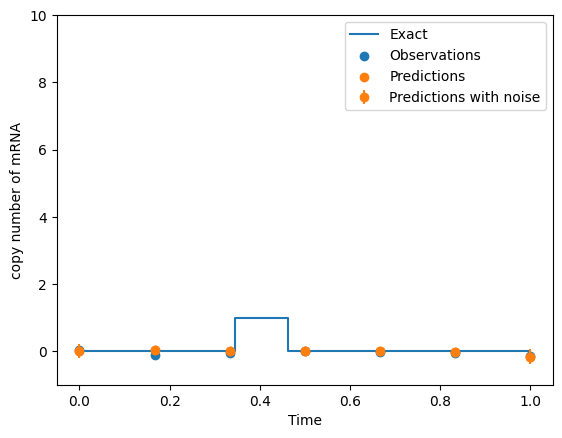

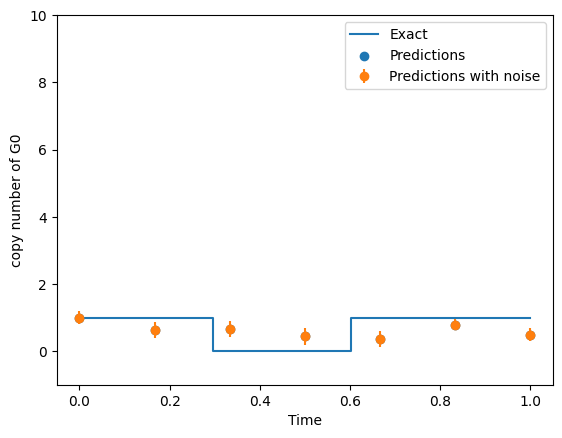

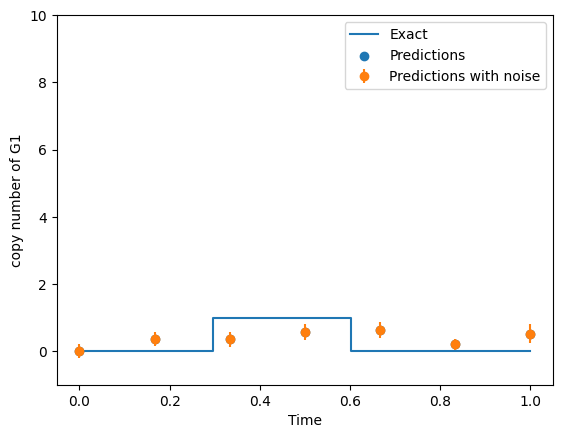

In [33]:
def trajecory_plotter(X, Y, chain, tgt, tgt_pred, tgt_sig_index, const_index, n_X_measurements_between_Y_measurements, device, sigma, obs_index=None, label=None):
    
    exact = []
    if not obs_index is None:
        observations = []
    predictions = []
    noise = []

    for i, t in enumerate(measurement_times[1:]):
        #print(f"t={t}")
        #print("Obs:", Y[i], "with X:", X[i*(n_X_measurements_between_Y_measurements+1)])
        #pred = chain[i].eval_baseline(t, X[i*(n_X_measurements_between_Y_measurements+1)].to(device).unsqueeze(0), Y[i+1:].unsqueeze(0).to(device))
        pred = chain[i].eval_baseline(t, X[i*(n_X_measurements_between_Y_measurements+1)].to(device).unsqueeze(0), Y[i+1:].unsqueeze(0).to(device))
        
        exact.append(X[i*(n_X_measurements_between_Y_measurements+1), tgt].item())
        if not obs_index is None:
            observations.append(Y[-(i+1)][0].item())
        predictions.append((pred[0][tgt_pred]/pred[0][const_index]).cpu().detach().numpy())
        noise.append(torch.abs(pred[0][tgt_sig_index]/pred[0][const_index] - (pred[0][tgt_pred]/pred[0][const_index])**2).cpu().detach().numpy())


    exact.append(X[0][tgt].item())
    if not obs_index is None:
        observations.append(Y[0][obs_index].item())
    predictions.append(X[0][tgt].item())
    noise.append(2*sigma)

    exact.reverse()
    if not obs_index is None:
        observations.reverse() 
    predictions.reverse()
    noise.reverse()

    plt.step(torch.linspace(0, tf, X.shape[0]), X[:, tgt], label='Exact', where='post')
    if not obs_index is None:
        plt.scatter(measurement_times, observations, label='Observations')
    plt.scatter(measurement_times, predictions, label='Predictions')
    plt.errorbar(measurement_times, predictions, yerr=noise, fmt='o', label='Predictions with noise')
    plt.legend()
    plt.xlabel('Time')
    if label is None:
        plt.ylabel('copy number')
    else:
        plt.ylabel('copy number of ' + label)

    plt.ylim([-1, 10])

    plt.show()


testing_trajectory = next(iter(val_dataset))
b = random.randint(0, testing_trajectory[0].shape[0]-1)
X = testing_trajectory[0][b]
Y = testing_trajectory[1][b]

trajecory_plotter(X, Y, chain, 2, 2, 6, 3, n_X_measurements_between_Y_measurements, device, sigma, obs_index=0, label='mRNA')
trajecory_plotter(X, Y, chain, 0, 0, 4, 3, n_X_measurements_between_Y_measurements, device, sigma, obs_index=None, label='G0')
trajecory_plotter(X, Y, chain, 1, 1, 5, 3, n_X_measurements_between_Y_measurements, device, sigma, obs_index=None, label='G1')


#trajecory_plotter(X, Y, chain, 2, 0, 2, 1, n_X_measurements_between_Y_measurements, device, sigma, obs_index=0, label='mRNA')


In [228]:
print(predictions)

NameError: name 'predictions' is not defined

In [69]:
df

,0,1,2,3,4,5
0,0.222000,0.152333,0.003667,0.000333,0.000000,0.000000
1,0.196333,0.216667,0.007333,0.001667,0.000667,0.000000
2,0.021667,0.031333,0.017333,0.002000,0.000333,0.000000
3,0.017333,0.028000,0.028000,0.009333,0.002000,0.000000
4,0.005000,0.010000,0.016333,0.007667,0.002333,0.000333


In [70]:
results

tensor([0.0039, 0.0066, 0.1002, 0.0310, 0.0033, 0.0133, 0.2947],
       device='cuda:0')

In [71]:
raise Exception("Stop here")

Exception: Stop here

### Neural Network setup

We omit the definition of the CRN, which is done at the beginning of the file

In [ ]:
from ElenaNetworks import NeuralMartingale, NeuralMartingaleChain
from OtherNetworks import RNNEncoder, MLP

from ElenaLosses import likelihood_GaussianNoise_unbatched, likelihood_constant_one

Delta = torch.tensor(MI.stoichiometric_matrix)

# we need a version of the h_function that is efficient for torch computations (maybe?)

hx_number_of_dimensions = 1
gx_number_of_dimensions = 2

class MLP_projecting(MLP):

    def __init__(self, *argv, **kwargs):
        super(MLP_projecting, self).__init__(*argv, **kwargs)
        pass

    def forward(self, x):
        # remove the 'k related' dimensions
        return super(MLP_projecting, self).forward(x[:, 0])
    

XEncoder = MLP(MI.get_number_of_species(), 32, 32, 2, activation=torch.nn.Tanh)
YEncoder = MLP_projecting(1, 32, 32, 2, activation=torch.nn.Tanh) #RNNEncoder(len(h_function), 64, activation=torch.nn.Tanh)
backbone = MLP(1+XEncoder.output_size+YEncoder.output_size, 16, gx_number_of_dimensions, 4, postprocessing_layer=torch.nn.Softplus(), activation=torch.nn.Tanh)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NN = NeuralMartingale(
    XEncoder, YEncoder, backbone,
    likelihood_GaussianNoise_unbatched,
    {"noise_covariance": 0.1*torch.eye(hx_number_of_dimensions)}, # covariance matrix (here the identity)
    lambda x: x[2],             # h_transform
    lambda x: x[0:2],        # g_function
    torch.tensor(MI.stoichiometric_matrix).to(device), # stoichiometry matrix
    n_X_measurements_between_Y_measurements, n_Y_measurements,
    Xtimes, Ytimes,
    gx_number_of_dimensions,
    device = device,
    paired_batch_size = 10,
    batch_size = batch_size
)

NN_chain = NeuralMartingaleChain(n_Y_measurements-1, NN.to(device)).to(device)
# print model size
print("total number of parameters: ", sum(p.numel() for p in NN_chain.chain[-1].parameters() if p.requires_grad))

total number of parameters:  6322


In [ ]:
X[1:3].shape

torch.Size([2, 203, 3])

In [ ]:
from DeepCME import split_overalp

X = next(iter(train_dataset))[0]

print(split_overalp(X[1:3], 3).shape)

torch.Size([2, 2, 102, 3])


### Training loop

now we have to define the training loop

In [ ]:
def inner_training_loop(model, k, train_loader, optimizer, n_epochs, validation_loader=None, scheduler=None):
    training_loss = []
    validation_loss = []
    for epoch in range(n_epochs):
        for i, (X, Y, R) in enumerate(train_loader):
            print(i)
            X = X.to(model.device)
            Y = Y.to(model.device)
            R = R.to(model.device)
            optimizer.zero_grad()
            loss = model.chain[k].loss(X, Y, R, k)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            if i % 10 == 0:
                print(f'Training: Epoch {epoch}, batch {i}, Loss {loss.item()}')
            training_loss.append((epoch*len(train_loader) + i, loss.item()))
        print(len(train_loader))
        print(f'per epoch training loss (batch average): {sum([training_loss[epoch*len(train_loader) + x][1] for x in range(len(train_loader))])/len(train_loader)}')
        if validation_loader is not None:
            for i, (X, Y, R) in enumerate(validation_loader):
                with torch.no_grad():
                    X = X.to(model.device)
                    Y = Y.to(model.device)
                    R = R.to(model.device)
                    loss = model.chain[k].loss(X, Y, R, k)
                    validation_loss.append((epoch*len(validation_loader) + i, loss.item()))
                    print(f'Validation: Epoch {epoch}, batch {i}, Loss {loss.item()}')
            print(f'per epoch validation loss (batch average): {sum([validation_loss[epoch*len(validation_loader) + x][1] for x in range(len(validation_loader))])/len(validation_loader)}')
    return training_loss, validation_loss
            

def outer_training_loop(model, train_loader, optimizer, n_epochs):
    for k in range(model.n_Y_measurements - 1):
        for epoch in range(n_epochs):
            for i, (X, Y, R) in enumerate(train_loader):
                
                X = X.to(model.device)
                Y = Y.to(model.device)
                R = R.to(model.device)
                optimizer.zero_grad()
                loss = model.loss(X, Y, R, k)
                loss.backward()
                optimizer.step()
                if i % 10 == 0:
                    print(f'Epoch {epoch}, Loss {loss.item()}')

optimizer = torch.optim.Adam(NN_chain.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=1.)
train_history, val_history = inner_training_loop(NN_chain, len(NN_chain.chain)-1, train_dataset, optimizer, 100, val_dataset, scheduler)

0
Training: Epoch 0, batch 0, Loss 2.005944013595581
1
2
3
4
5
per epoch training loss (batch average): 0.859007966518402
Validation: Epoch 0, batch 0, Loss 0.7401360273361206
Validation: Epoch 0, batch 1, Loss 0.4614514410495758
Validation: Epoch 0, batch 2, Loss 0.7796158194541931
Validation: Epoch 0, batch 3, Loss 0.4553094506263733
Validation: Epoch 0, batch 4, Loss 0.6632491946220398
per epoch validation loss (batch average): 0.6199523866176605
0
Training: Epoch 1, batch 0, Loss 0.5184557437896729
1
2
3
4
5
per epoch training loss (batch average): 0.5098745703697205
Validation: Epoch 1, batch 0, Loss 0.6359116435050964
Validation: Epoch 1, batch 1, Loss 0.39916789531707764
Validation: Epoch 1, batch 2, Loss 0.6391560435295105
Validation: Epoch 1, batch 3, Loss 0.1773383915424347
Validation: Epoch 1, batch 4, Loss 0.5949072241783142
per epoch validation loss (batch average): 0.4892962396144867
0
Training: Epoch 2, batch 0, Loss 0.9360252618789673
1
2
3
4
5
per epoch training loss (

In [ ]:
[ x.shape for x in next(iter(val_dataset))]
# plot the training and validation loss

[torch.Size([100, 102, 3]), torch.Size([100, 2, 1]), torch.Size([100, 102, 4])]

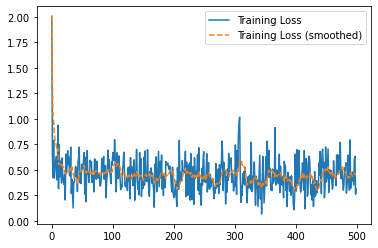

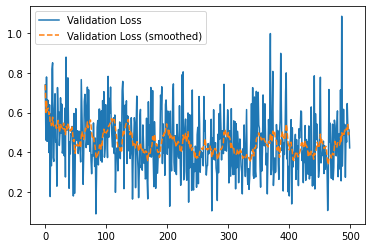

In [ ]:
# plot the training and validation loss
plt.plot([x[0] for x in train_history], [x[1] for x in train_history], label='Training Loss')
# running average
plt.plot([x[0] for x in train_history], [np.mean([train_history[i][1] for i in range(max(0, x-10), x+1)]) for x in [x[0] for x in train_history]], label='Training Loss (smoothed)', linestyle='--')    
plt.legend()
plt.show()

plt.plot([x[0] for x in val_history], [x[1] for x in val_history], label='Validation Loss')
# running average
plt.plot([x[0] for x in val_history], [np.mean([val_history[i][1] for i in range(max(0, x-10), x+1)]) for x in [x[0] for x in val_history]], label='Validation Loss (smoothed)', linestyle='--')
plt.legend()
plt.show()

In [ ]:
# plot the history
# # make lines thinner
# plt.plot([i for i,x in enumerate(NN_chain.chain[-1].history["G"])], [x.item() for x in (NN_chain.chain[-1].history["G"])], label='G', linewidth=0.5)
# plt.plot([i for i,x in enumerate(NN_chain.chain[-1].history["SI"])], [x.item() for x in (NN_chain.chain[-1].history["SI"])], label='SI')
# plt.plot([i for i,x in enumerate(NN_chain.chain[-1].history["NN"])], [x.item() for x in (NN_chain.chain[-1].history["NN"])], label='NN')
# plt.title("Sum")
# plt.legend()
# plt.show()
# # and the standard deviations
# plt.plot([i for i,x in enumerate(NN_chain.chain[-1].history["Gs"])], [x.item() for x in (NN_chain.chain[-1].history["Gs"])], label='G', linewidth=0.5)
# plt.plot([i for i,x in enumerate(NN_chain.chain[-1].history["SIs"])], [x.item() for x in (NN_chain.chain[-1].history["SIs"])], label='SI')
# plt.plot([i for i,x in enumerate(NN_chain.chain[-1].history["NNs"])], [x.item() for x in (NN_chain.chain[-1].history["NNs"])], label='NN')
# plt.legend()
# plt.title("Standard deviations")
# plt.show()


In [ ]:
out = NN_chain.chain[-1].forward(torch.tensor(0.).cuda(), torch.tensor([[0.,1.,0.]]).cuda(), torch.tensor([[[100000.]]]).cuda())
out#/out.sum()

tensor([[0.1959, 0.1534]], device='cuda:0', grad_fn=<SoftplusBackward0>)

## Other